# Actividad práctica: Predicción de series de tiempo

En esta tarea se pide entrenar y evaluar un predictor para la serie de tiempo Mackey-Glass. Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = 0.2 \frac{ y(t-\tau)}{1 + y(t-\tau)^{10}} - 0.1 y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

- Siga las instrucciones en este notebook para resolver el problema de predicción
- Conteste las preguntas que se encuentran en este enunciado
- Finalmente envíe su notebook con los resultados y respuestas a phuijse@inf.uach.cl
- No olvide cambiar el título para reflejar los integrantes de su grupo

In [36]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
import pandas as pd

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

***

Use el código que se muestra a continuación para generar la serie de tiempo Mackey Glass

- Considere una razón señal a ruido (SNR) de 2.
- Considere $\tau=17$ (comportamiento debilmente caótico)

Se generaran 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar y los siguientes 500 puntos para hacer predicción

<IPython.core.display.Javascript object>


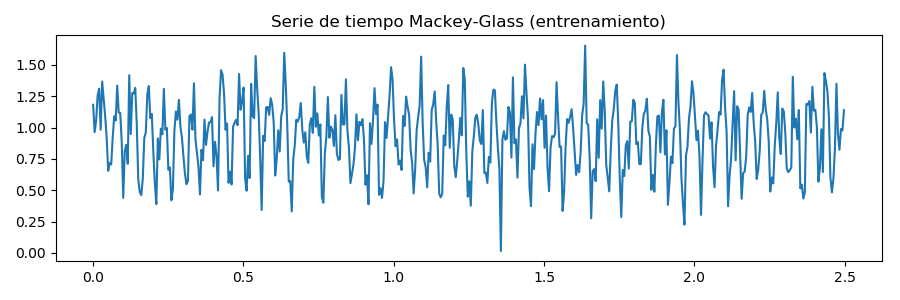

In [64]:
N = 1000 # número de observaciones (no modificar)
SNR = 2. # Razón señal a ruido (2., 0.5)
a, b = 0.1, 0.2 # constantes de la ecuación diferencial (no modificar)
tau = 17. # comportamiento dinámico de Mackey-Glass (17, 30)
dt = 0.05# paso de integración (no modificar)
y0 = 0.9 # condición incial (no modificar)
tt = 5.# largo temporal (no modificar)

t = np.linspace(0, tt, num=N)
#arreglo empieza en 0, termina en tt, N muestras

N_full, tau_full = int(N*tt/dt), int(tau/dt)

ymg = y0*np.ones(shape=(N_full, ))


# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;


ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 


# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))


# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

***

1. Describa en detalle el algoritmo LMS indicando sus semejanzas y diferencias con el filtro de Wiener
    
El algoritmo LMS(del ingles Least-Mean-Square) es un algoritmo usado en filtros adaptativos para encontrar los coeficientes del filtro que permiten obtener el valor minimo esperado del cuadrado de la señal de error (diferencia entre la señal deseada y la señal producida por el filtro). Pertenece a la familia de algoritmos de gradiente estocasticos, es decir, el filtro se adapta en base al gradiente de la tendencia estadistica, que se produce al relacionar la señal a filtrar con la señal de ruido. Es la aplicacion de un filtro FIR. Es el algoritmo mas simple (o estandar) de los algoritmos adaptivos, su objetivo consiste en la reduccion de ruido (usando metodos estadisticos) en la señal que tomamos como entrada ,para que la salida se aproxime lo mas posible a la señal que queremos obtener, es decir la señal deseada.

El algoritmo LMS tiene 2 prcesos basicos:
 * proceso de filtrado : Filtrado de la señal de entrada, se realiza un calculo de la salida generada por un filtro y la generación del error comparando dicha salida con la respuesta deseada.
 * proceso adaptativo : se hace un ajuste de los coeficientes del filtro de forma automatica según la estimación del error.
 
La solución del filtro LMS converge a la solución del filtro de Wiener , asumiendo que la solución del sistema desconocido es LTI y el ruido es estacionario, ambos filros se pueden utilizar para identificar la respuesta al impulso de un sistema desconocido, conociendo solamente la señal de entrada original y la salida del sistema desconocido. Al mitigar el criterio de error para reducir el error muestral actual en vez de minimizar el error total a lo largo de todo n, el algoritmo de LMS puede ser derivado del filtro de Wiener.

Ambos filtros son estimadores/Predictores, los 2 tratan de estimar los coeficientes del filtro lineal que minimiza la funcion de costo MMSE(minimum mean square error).

El filtro de Wiener asume la data (muestra de entrenamiento) ya dada para asi calcular una solución optima,en cambio LMS es una solución sub-optima ya que solo calcula el optimo en el instante (optimo local) ya que con su capacidad de automejorarse recursivamente en tiempo real (sin volver a ejecutar el algoritmo completo con información nueva, se logra obtener un costo de rendimiento (en cuanto a optimización) mucho mejor en comparación con el filtro de Wiener. 


2. Partiendo del error instantaneo $J_n^s(\textbf{w}) = e_n^2$ derive la regla de actualización de pesos
Partiendo de:

\begin{align}
J^s_n(\textbf{w}) &= e_n^2 \nonumber \\
&= (d_n - y_n)^2 \nonumber \\
&= (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} )^2 \nonumber  \\ 
\tag{1} 
\end{align}

Calculando la derivada se tiene que:

\begin{equation}
\frac{dJ(w)}{dw} =   2 (d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k})  u_{n-k}
\tag{2}
\end{equation}

Y recordando que 

\begin{equation}
e_n = d_n - y_n
\tag{3}
\end{equation}

Sustituyendo (3) en (2) tenemos la siguiente expresión:

\begin{equation}
\frac{dJ(w)}{dw} =   2 e_n u_{n-k}
\end{equation}

Y sea $w_n$ el peso de los coeficientes en el filtro y $\mu$ como tasa de aprendizaje o "paso", usando SGD (ya que como estamos calculando para LMS que es una versión mas simplista del filtro de Wiener) " $J_n^s(\textbf{w}) = e_n^2$" tenemos que:

\begin{equation}
w_{t+1} = w_t - \mu \frac{dJ(w)}{dw}
\tag{4}
\end{equation}

Finalmente, reemplazando en (4) obtenemos que la regla de actualización de pesos es:

\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n-k}\nonumber \\
\end{align}

3. La siguiente clase de *Python* predice y entrena un filtro LMS. Complete la línea que dice 

` self.w = ? `

con el valor correcto de actualización de peso del filtro LMS

\begin{align}
\textbf{w}_{n+1} &= \textbf{w}_{n} + 2 \mu e_n \textbf{u}_{n-k}\nonumber \\
\end{align}

In [65]:
class LMS_filter(object):
    
    def __init__(self, L=1, mu=0.5, normalized=True):
        self.L = L
        self.mu = mu
        self.w = np.zeros(shape=(L, ))
        self.normalized = normalized
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)#producto punto de W y U
    
    def update(self, u, d):
        d_pred = self.predict(u)
        norm = 1.
        if self.normalized:
            norm = np.sum(u**2) + 1e-6
        e = (d-d_pred)
        self.w = self.w + 2*self.mu*e*u/norm

***
## Predicción con algoritmo LMS

1. Entrene el predictor con el algoritmo normalized LMS usando el siguiente bloque de código
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\mu$ y $L$
    - Se recomienda hacer un barrido logarítmico en $\mu$ (por ejemplo `mu=np.logspace(-2, 0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
***

1. Repita el experimento para $\tau = 30$ (comportamiento fuertemente caótico) 
1. Compare los resultados obtenidos con cada serie de tiempo. ¿Qué casos son más sencillos y cuales más complicados?


Usando $L$ = 5,10,20,30,  $\tau = 17$ $\mu = $variable entre -2 y 0

In [66]:
mu = np.logspace(-2, 0, num=20)#barrido logaritmico para variar mu
L = [5, 10, 20, 30]#Valores para variar L

df = np.zeros((len(mu), len(L)*2)) # dataframe con 20 filas y 8 columnas que se subdividen en 4 para los NMSE de entranamiento y prueba

pruebas = {"optimo": [],"medio": [],"inestable": []} #para guardar los valores de las pruebas

#variables donde guardaremos los valores optimos 
opm = 0
opl = 0
opn = 9999999 #valor alto para ir mejorando con el menor NMSE

aux1=0
for i in mu:
    aux2=0
    aux3=0
    for j in L:
        lms = LMS_filter(L=j, mu=i, normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(u=y_window, d=y_obs[k])
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        
        # Capturando pruebas
        if (aux1 == 9 and aux3 == 3):
            pruebas["optimo"] = y_pred
        elif (aux1 == 13 and aux3 == 2):
            pruebas["medio"] = y_pred
        elif (aux1 == 14 and aux3 == 1):
            pruebas["inestable"] = y_pred
        

        entrenamiento = NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500])
        prueba = NMSE(ymg[500:], y_pred[500:])
        
        if (prueba < opn):
            opm = aux1 #optimo de mu
            opl = aux3 #optimo de L
            opn = prueba#optimo MSE de prueba
        df[aux1][aux2] = np.format_float_scientific(entrenamiento, 7)
        df[aux1][aux2+1] = np.format_float_scientific(prueba, 7)
        
        aux3 += 1
        aux2 += 2
    aux1 += 1

print("mejor mu: " + str(mu[opm]) + ", mejor L: " + str(L[opl]) + ", MSE de prueba: " + str(opn))
print("peor mu: " + str(mu[19]) + ", peor L: " + str(L[0]) + ", MSE de prueba: " + str(df[19][1]))
print("mu medio: " + str(mu[13]) + ", L medio: " + str(L[2]) + ", MSE de prueba: " + str(df[13][5]))
    
    

mejor mu: 0.08858667904100823, mejor L: 30, MSE de prueba: 187.91561016282552
peor mu: 1.0, peor L: 5, MSE de prueba: 94442.719
mu medio: 0.23357214690901212, L medio: 20, MSE de prueba: 273.61276


# Data frame con valores de NMSE

In [67]:
pd.DataFrame(df, columns=["L=5 entrenamiento","L=5 prueba", "L=10 entrenamiento", "L=10 prueba", "L=20 entrenamiento", "L=20 prueba", "L=30 entrenamiento", "L=30 prueba"])

L=5 entrenamiento   L=5 prueba  L=10 entrenamiento   L=10 prueba  \
0          1227.87540    772.85941           912.09905     423.23028   
1          1136.92040    737.47381           804.23052     397.23155   
2          1058.87280    699.63728           713.67271     369.69370   
3           990.57804    660.83720           635.91783     342.03376   
4           930.76345    622.75824           568.64921     316.11199   
5           879.28133    587.18040           511.08679     293.96684   
6           836.28797    555.90646           463.09653     277.33841   
7           801.89546    530.89060           424.52261     267.08655   
8           776.41860    514.48872           394.95418     262.80051   
9           760.87224    509.46698           373.83567     263.09126   
10          757.27888    518.47173           360.74840     266.95407   
11          768.60705    543.27319           355.71219     275.86316   
12          798.57131    584.66049           359.35494     295.69284   
13          851.90817    645.37964           372.95413     339.09695   
14          936.24328    748.34829           398.72987     431.73311   
15         1068.21670   1006.64490           441.24610     624.34517   
16         1291.63540   1772.73610           512.33466    1007.39510   
17         1738.86460   3777.32720           649.90714    1808.11680   
18         3023.39590   8874.57270          1032.44270    5186.23620   
19       123371.81000  94442.71900         46336.22100  249576.52000   

    L=20 entrenamiento  L=20 prueba  L=30 entrenamiento  L=30 prueba  
0            902.90376    384.04883           886.42052    393.91738  
1            794.98792    356.40785           780.53695    367.70992  
2            704.57338    326.18650           692.56055    338.82778  
3            626.49684    294.54077           616.85319    308.24675  
4            557.82102    263.24086           549.89654    277.45550  
5            497.42285    234.60747           490.10847    248.36634  
6            445.22306    211.29791           437.24531    223.11385  
7            401.43655    195.90006           391.66776    203.76819  
8            366.09977    190.28607           353.75686    191.89525  
9            338.87636    194.81113           323.58430    187.91561  
10           319.07171    207.82017           300.82722    190.61096  
11           305.85401    226.24449           284.90813    197.54933  
12           298.65071    247.71246           275.29975    206.79464  
13           297.57945    273.61276           271.91241    219.07240  
14           303.76873    311.99167           275.61181    239.26609  
15           319.59604    380.10407           289.03500    277.78013  
16           349.60344    506.63620           318.12173    353.58180  
17           406.02310    735.34364           377.19472    502.99525  
18           546.01051   1184.10270           522.92120    807.07088  
19          6312.37030   3061.58540          5885.70280  23877.50100

## Graficos para los valores optimos de $\mu$ y $L$

<IPython.core.display.Javascript object>


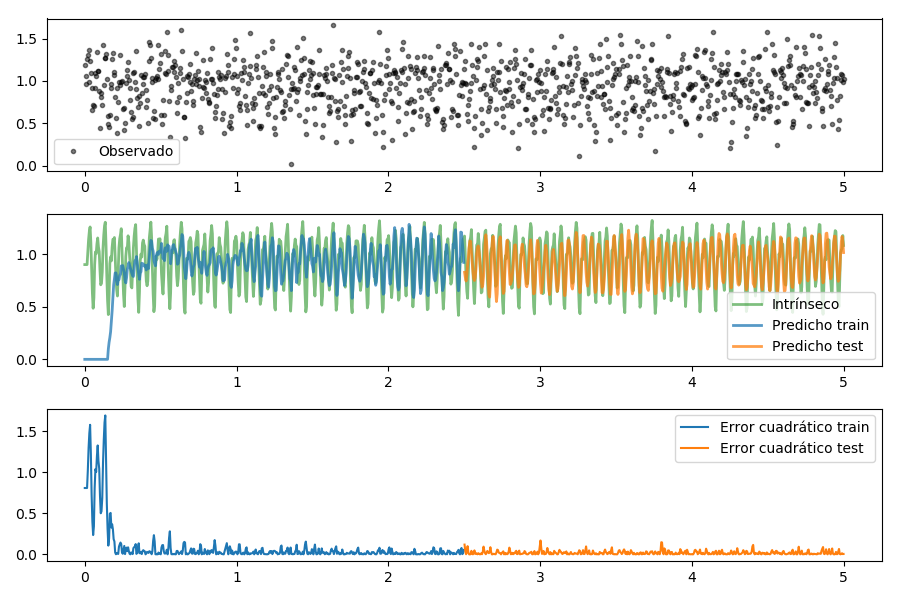

In [68]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], pruebas["optimo"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], pruebas["optimo"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - pruebas["optimo"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - pruebas["optimo"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Graficos para los valores medios de $\mu$ y $L$

<IPython.core.display.Javascript object>


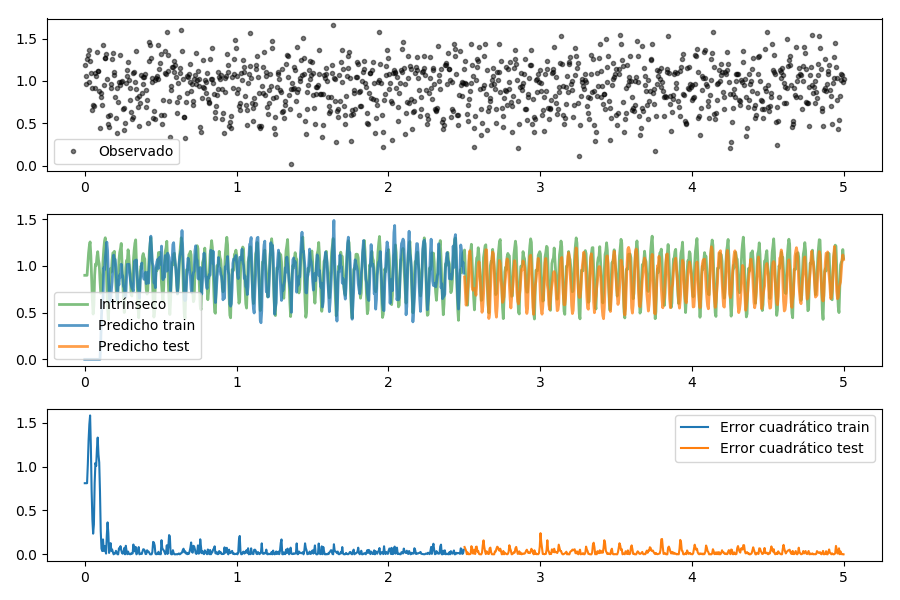

In [69]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], pruebas["medio"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], pruebas["medio"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - pruebas["medio"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - pruebas["medio"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Graficos para los valores inestables de $\mu$ y $L$

<IPython.core.display.Javascript object>


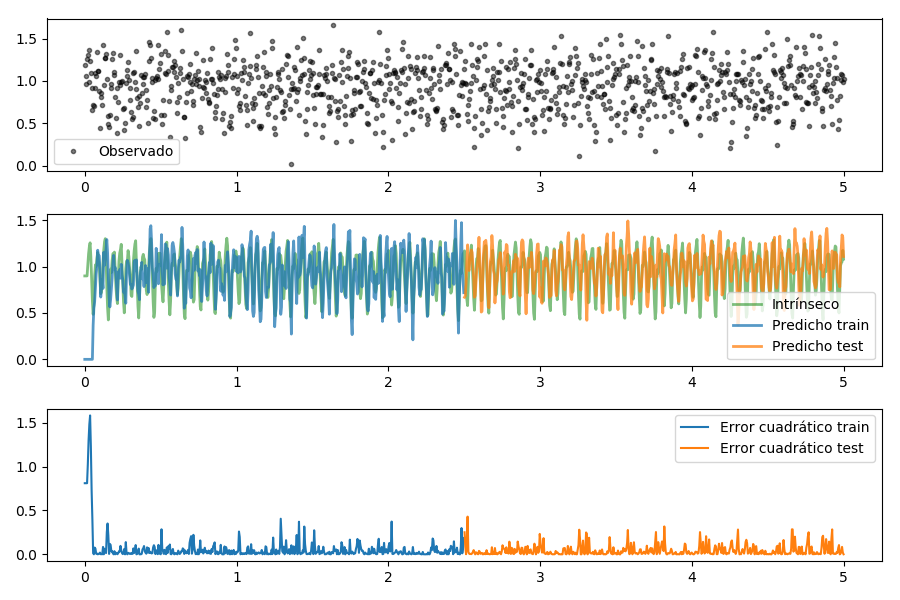

In [70]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], pruebas["inestable"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], pruebas["inestable"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - pruebas["inestable"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - pruebas["inestable"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

## Ahora cambiar $\tau = 30$

<IPython.core.display.Javascript object>


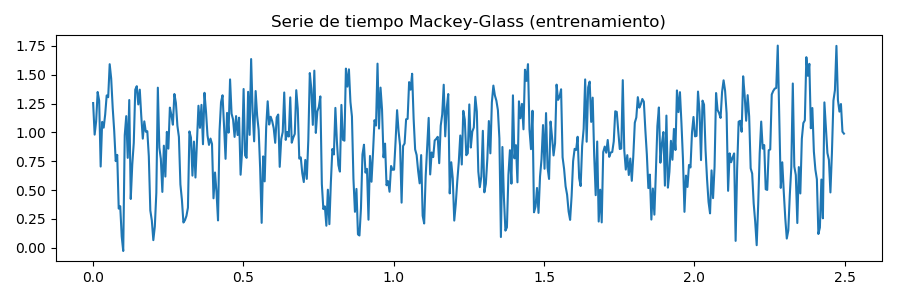

In [71]:
N = 1000 # número de observaciones (no modificar)
SNR = 2. # Razón señal a ruido (2., 0.5)
a, b = 0.1, 0.2 # constantes de la ecuación diferencial (no modificar)
tau = 30. # comportamiento dinámico de Mackey-Glass (17, 30)
dt = 0.05# paso de integración (no modificar)
y0 = 0.9 # condición incial (no modificar)
tt = 5.# largo temporal (no modificar)

t = np.linspace(0, tt, num=N)
#arreglo empieza en 0, termina en tt, N muestras

N_full, tau_full = int(N*tt/dt), int(tau/dt)

ymg = y0*np.ones(shape=(N_full, ))


# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;


ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 


# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))


# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

## Usando los mismos valores anteriores pero ahora con $\tau = 30$

In [72]:
mu = np.logspace(-2, 0, num=20)#barrido logaritmico para variar mu
L = [5, 10, 20, 30]#Valores para variar L

df = np.zeros((len(mu), len(L)*2)) # dataframe con 20 filas y 8 columnas que se subdividen en 4 para los NMSE de entranamiento y prueba

pruebas = {"optimo": [],"medio": [],"inestable": []} #para guardar los

#variables donde guardaremos los valores optimos 
opm = 0
opl = 0
opn = 9999999 #valor alto para ir mejorando con el menor NMSE

aux1=0
for i in mu:
    aux2=0
    aux3=0
    for j in L:
        lms = LMS_filter(L=j, mu=i, normalized=True)
        # Entrenamiento
        y_pred = np.zeros(shape=(len(y_obs), ))
        for k in range(lms.__len__(), 500):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
            lms.update(u=y_window, d=y_obs[k])
        # Prueba
        for k in range(500, len(y_obs)):
            y_window = y_obs[k-lms.__len__():k]
            y_pred[k] = lms.predict(y_window)
        
        # Capturando pruebas
        if (aux1 == 9 and aux3 == 3):
            pruebas["optimo"] = y_pred
        elif (aux1 == 13 and aux3 == 2):
            pruebas["medio"] = y_pred
        elif (aux1 == 14 and aux3 == 1):
            pruebas["inestable"] = y_pred
        

        entrenamiento = NMSE(ymg[lms.__len__():500], y_pred[lms.__len__():500])
        prueba = NMSE(ymg[500:], y_pred[500:])
        
        if (prueba < opn):
            opm = aux1
            opl = aux3
            opn = prueba
        df[aux1][aux2] = np.format_float_scientific(entrenamiento, 7)
        df[aux1][aux2+1] = np.format_float_scientific(prueba, 7)
        
        aux3 += 1
        aux2 += 2
    aux1 += 1

print("mejor mu: " + str(mu[opm]) + ", mejor L: " + str(L[opl]) + ", MSE de prueba: " + str(opn))
print("peor mu: " + str(mu[19]) + ", peor L: " + str(L[0]) + ", MSE de prueba: " + str(df[19][1]))
print("mu medio: " + str(mu[13]) + ", L medio: " + str(L[2]) + ", MSE de prueba: " + str(df[13][5]))
    

mejor mu: 0.06951927961775606, mejor L: 20, MSE de prueba: 316.133278701211
peor mu: 1.0, peor L: 5, MSE de prueba: 446613.87
mu medio: 0.23357214690901212, L medio: 20, MSE de prueba: 596.68017


# Dataframe de NMSE para $\tau = 30$

In [73]:
pd.DataFrame(df, columns=["L=5 entrenamiento","L=5 prueba", "L=10 entrenamiento", "L=10 prueba", "L=20 entrenamiento", "L=20 prueba", "L=30 entrenamiento", "L=30 prueba"])

L=5 entrenamiento    L=5 prueba  L=10 entrenamiento  L=10 prueba  \
0           757.43894     484.93771           870.85517    575.73650   
1           703.71135     468.75168           808.26564    548.91806   
2           657.68697     451.33370           753.36615    520.86226   
3           617.53584     433.04409           703.98465    492.92924   
4           582.71906     414.37207           659.27834    466.71731   
5           553.51610     396.20673           619.39730    444.11555   
6           530.49512     379.89639           584.97900    427.11933   
7           514.21867     367.07000           556.71143    417.44291   
8           505.22293     359.42684           535.08086    416.09057   
9           504.12234     359.18237           520.27671    423.32960   
10          511.80280     371.12932           512.20298    439.82613   
11          529.94402     406.84134           510.63943    470.15359   
12          562.11435     490.53785           515.70137    530.38934   
13          615.42602     666.62883           528.77521    659.52681   
14          703.38656    1012.34590           554.08608    928.55365   
15          853.55842    1656.06120           601.48178   1446.14600   
16         1132.26460    2787.57400           693.85757   2388.37650   
17         1745.62430    4736.44580           897.17714   4116.37240   
18         3793.70990   11101.46400          1519.27760   7629.61030   
19       196930.62000  446613.87000         35167.71800  44750.85700   

    L=20 entrenamiento   L=20 prueba  L=30 entrenamiento  L=30 prueba  
0            767.26941     442.65827           756.82073    428.18495  
1            700.75418     422.04793           692.23804    409.30977  
2            644.34443     400.35381           637.89352    389.44987  
3            594.56247     378.76632           590.01740    369.85237  
4            549.46017     358.65720           546.23309    351.97134  
5            508.42383     341.34644           505.50006    337.18348  
6            471.67856     327.88382           467.72619    326.48667  
7            439.79304     319.11206           433.26897    320.52059  
8            413.41394     316.13328           402.56513    320.03928  
9            393.22169     321.08832           375.97558    326.62964  
10           379.95530     338.28364           353.79194    343.67867  
11           374.41156     376.20519           336.32611    378.01441  
12           377.46135     451.58123           324.04059    442.16368  
13           390.16014     596.68017           317.70146    556.12624  
14           413.96515     869.14951           318.55202    746.76540  
15           451.24934    1371.86560           328.58697   1045.30470  
16           507.39624    2352.29860           351.37366   1495.88740  
17           600.51051    4662.21870           395.96584   2181.16570  
18           821.75330   12121.76300           504.18162   3149.44340  
19          8394.32590  106860.46000          2606.81100   7095.57870

# Graficas

<IPython.core.display.Javascript object>


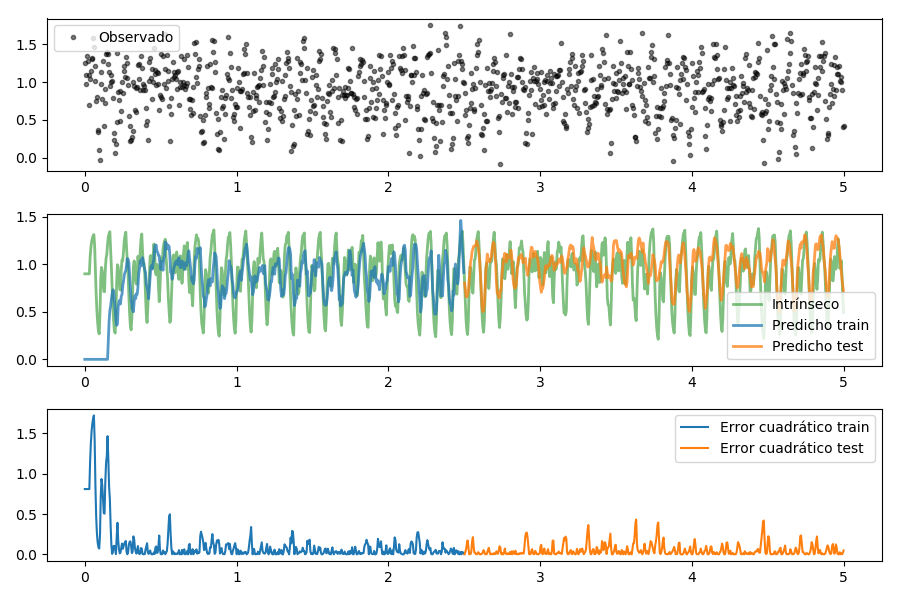

In [74]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], pruebas["optimo"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], pruebas["optimo"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - pruebas["optimo"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - pruebas["optimo"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

<IPython.core.display.Javascript object>


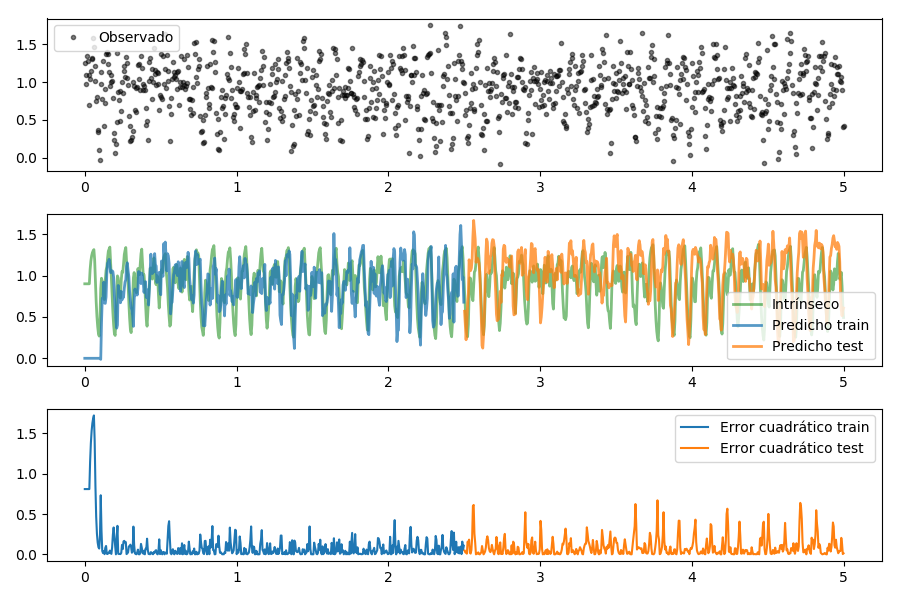

In [75]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], pruebas["medio"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], pruebas["medio"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - pruebas["medio"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - pruebas["medio"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

<IPython.core.display.Javascript object>


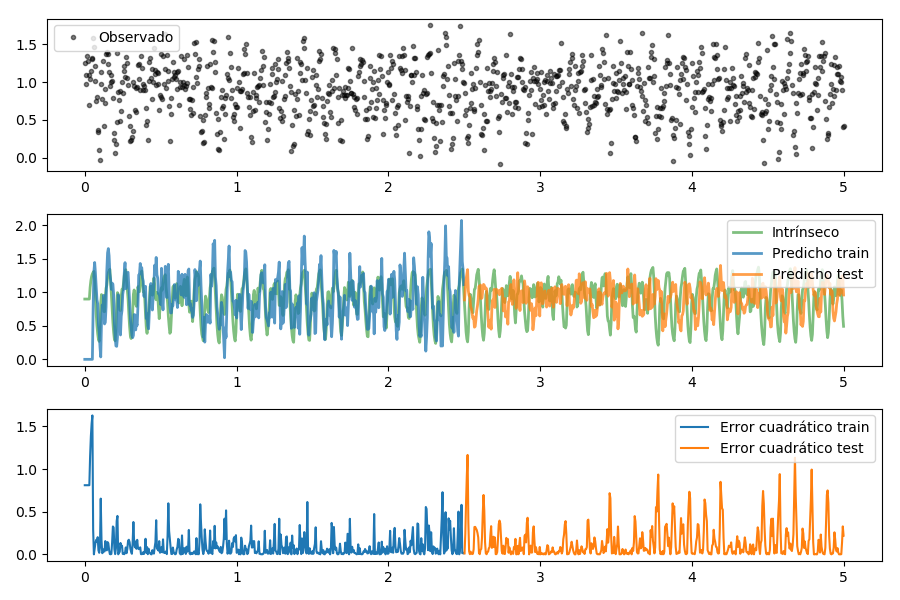

In [76]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], pruebas["inestable"][:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], pruebas["inestable"][500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - pruebas["inestable"][:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - pruebas["inestable"][500:])**2, label='Error cuadrático test'); ax[2].legend(); 

***
## Predicción con algoritmo RLS

1. Describa en detalle el algoritmo RLS indicando sus semejanzas y diferencias con el algoritmo LMS

El algoritmo RLS se basa en el algoritmo LMS, pero ocupando caracteristicas acumulativas / recursivas, que permiten que el algoritmo se adapte mas rápido, lo que implica una convergencia más rápida del algoritmo.

Ambos son metodos sequenciales/onLine que resuelven el mismo problema,si la data previamente dada es estacionaria ambos metodos pueden converger a la misma solución.

Ambos pueden ajustarse con los datos , por lo tanto, son favorables cuando el sistema cambie en el tiempo.

La ventaja de RLS sobre LMS es que converge mas rápido a la solución. Su gran desventaja es que tiene mayor complejidad/costo computacional (O(L²) > O(L)).


2. Partiendo del error histórico $J_N(\textbf{w}) = \sum_{i=1}^N \beta^{N-i} e_i^2$ derive la regla recursiva de actualización de pesos 

Sea: 

\begin{align}
J^H_n(\textbf{w}) &= \sum_{i=L}^n   \beta^{n-i} |e_i|^2 \nonumber \\
\end{align}

Derivamos e igualamos a cero para obtener el optimo

$$
\begin{align}
\frac{d J^H_n (\textbf{w})}{d w_{n, k}} &= 2 \sum_{i=1}^n   \beta^{n-i} e_i \frac{de_i}{d w_{n, k}} = 0
\nonumber \\
\tag{1}
\end{align}
$$

Recordando que:
$$
\begin{align}
e_n = d_n - \sum_{k=0}^{L} w_{n, k} u_{n-k} \nonumber 
\tag{2}
\end{align}
$$
Y que:
$$
\begin{align}
\frac{de_i}{d w_{n, k}} &= u_{n-k}
\tag{3}
\end{align}
$$
Reemplazando (2) y (3) en (1) obtenemos:

$$
\begin{align}
\frac{d J^H_n (\textbf{w})}{d w_{n, k}} &= 2 \sum_{i=1}^n   \beta^{n-i} [d_i - \sum_{k=0}^{L} w_{n, k} u_{n-k}]u_{n-k} = 0
\nonumber \\
\end{align}
$$
Nos queda la siguiente ecuación:
$$
\begin{align}
\sum_{i=1}^n   \beta^{n-i} [d_i - \sum_{l=0}^{L} w_{n, k} u_{i-l}]u_{i-k} = 0
\nonumber \\
\tag{4}
\end{align}
$$

Reordenando la ecuacion (4) nos queda:
$$
\begin{align}
\sum_{l=1}^L  w_{n, k} [ \sum_{i=0}^{n}  \beta^{n-i} u_{i-l}u_{i-k}] = \sum_{i=0}^{n}  \beta^{n-i} d_i u_{i-k}
\nonumber \\
\tag{5}
\end{align}
$$

Definiendo las matrices que componen la solucion cerrada:

$$
\textbf{d}_n = \begin{pmatrix}  d_n \\ d_{n-1} \\ \vdots \\ d_{L+1} \end{pmatrix} \quad
\textbf{u}_n = \begin{pmatrix}  u_n \\ u_{n-1} \\ \vdots \\ u_{n-(L+1)} \end{pmatrix} \quad
\pmb{\beta} = I \begin{pmatrix} \beta \\ \beta^{1} \\ \beta^{2}  \vdots \\ \beta^{n-L-1} \end{pmatrix}
\quad 
U_n = \begin{pmatrix}
\textbf{u}_n^T \\ \textbf{u}_{n-1}^T \\ \vdots \\ \textbf{u}_{L+1}^T \\
\end{pmatrix} \in \mathbb{R}^{n - (L+1) \times L+1}
$$

Y agregando el regularizador de pesos:
$$
J^w_n = \delta  \| \textbf{w}_{n} \|^2
$$

Por lo que la forma matricial de la ecuación (5)o solución cerrada:

$$
\textbf{w}_n (U_n^T \pmb{\beta} U_n + \delta I) = U_n^T \pmb{\beta} \textbf{d}_n $$


$$
\textbf{w}_n = (U_n^T \pmb{\beta} U_n + \delta I)^{-1} U_n^T \pmb{\beta} \textbf{d}_n$$

Expresar la forma matricial enterminos mas simples:  

  - Matriz de correlación ponderada y regularizada: $\Phi_n = U_n^T \pmb{\beta} U_n + \delta I$
  - Vector de correlación cruzada ponderada:  $\theta_n = U_n^T \pmb{\beta} \textbf{d}_n$
  
Quedando finalmente:
$$
\begin{align}
\textbf{w}_n = \Phi_n^{-1} \theta_n
\end{align}
$$

3. La siguiente clase de *Python* predice y entrena un filtro RLS. Complete las líneas que dice 

` self.w = ? ` y `self.Phi_inv = `

con el valor correcto de actualización de peso del filtro RLS

$$
\textbf{w}_n = \textbf{w}_{n-1} + \textbf{k}_n e_n 
$$
    
$$
\Phi_{n}^{-1} = \beta^{-1} \Phi_{n-1}^{-1} - \beta^{-1} \textbf{k}_n \textbf{u}_n^T \Phi_{n-1}^{-1}
$$

In [8]:
class RLS_filter(object):
    
    def __init__(self, L=1, beta=0.9, delta=10.):
        self.L = L
        self.beta = beta
        self.w = np.zeros(shape=(L, ))
        self.Phi_inv = delta*np.eye(L)
    
    def __len__(self):
        return self.L
    
    def predict(self, u):
        return np.dot(self.w, u)
    
    def update(self, u, d):          
        invbeta = 1.0/self.beta
        d_pred = self.predict(u)
        e = d - d_pred
        r = 1. + invbeta*np.dot(np.dot(u, self.Phi_inv), u.T)
        k = invbeta*np.dot(self.Phi_inv, u)/r       
        self.Phi_inv = invbeta*self.Phi_inv - invbeta*k*d_pred*self.Phi_inv
        self.w = self.w + k*e
        

***

1. Entrene el predictor con el algoritmo RLS usando el siguiente bloque de código
1. Considere primero  $\tau=17$
1. Construya una tabla con los NMSE de entrenamiento y prueba para distintos valores de $\beta$ y $L$
    - Se recomienda hacer un barrido lineal en $\beta$ (por ejemplo `mu=np.linspace(0.8, 1.0, num=20)`)
    - Use al menos los siguientes valores de $L$: [5, 10, 20, 30]
1. Describa cada experimento analizando sus resultados de forma cuantitativa y cualitativa
    - ¿Cuánto demora el filtro en estabilizarse? 
    - ¿Se sobreajuste el filtro a los datos de entrenamiento? 
    - ¿Se desestabiliza el filtro?
1. Indique que combinación obtiene menor MSE de prueba 
1. Repita el experimento para $\tau=30$
1. Compare con los resultados obtenidos con el algoritmo LMS ¿Qué algoritmo demora menos en converger?


usando L=5 y $\tau = 17$

In [20]:
rls = RLS_filter(L=5, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 238.6437, prueba 606.3019


<IPython.core.display.Javascript object>


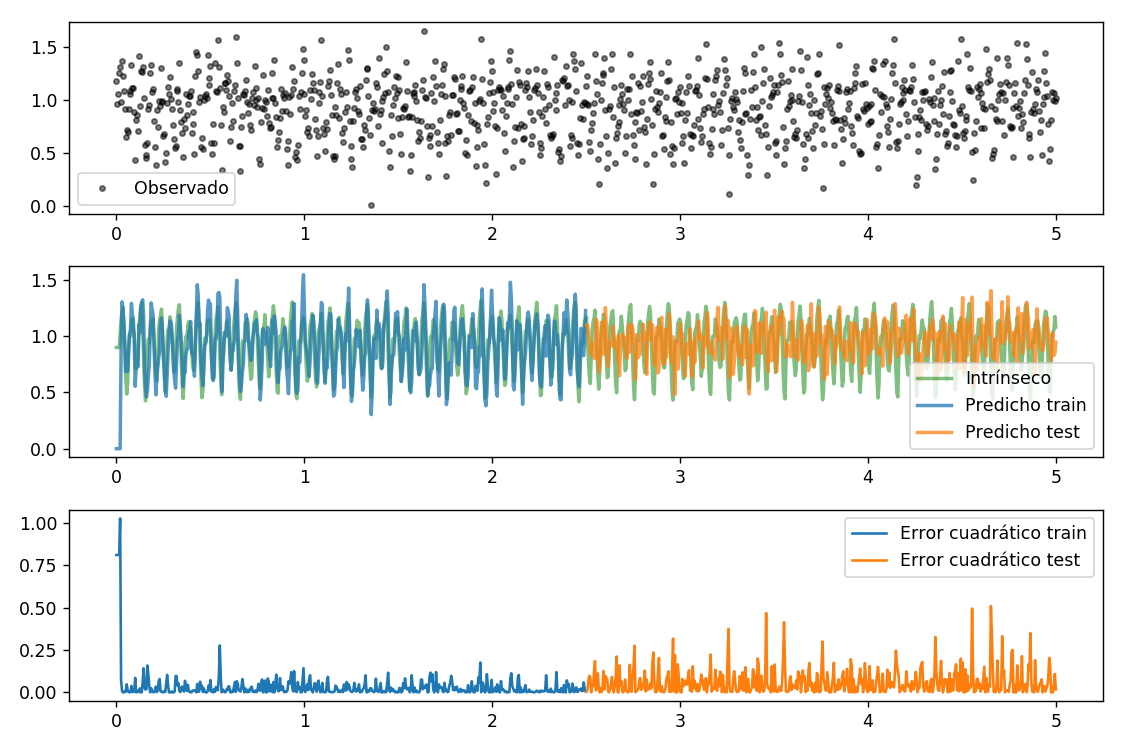

In [21]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=10 y $\tau = 17$

In [23]:
rls = RLS_filter(L=10, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 233.2099, prueba 1094.7570


<IPython.core.display.Javascript object>


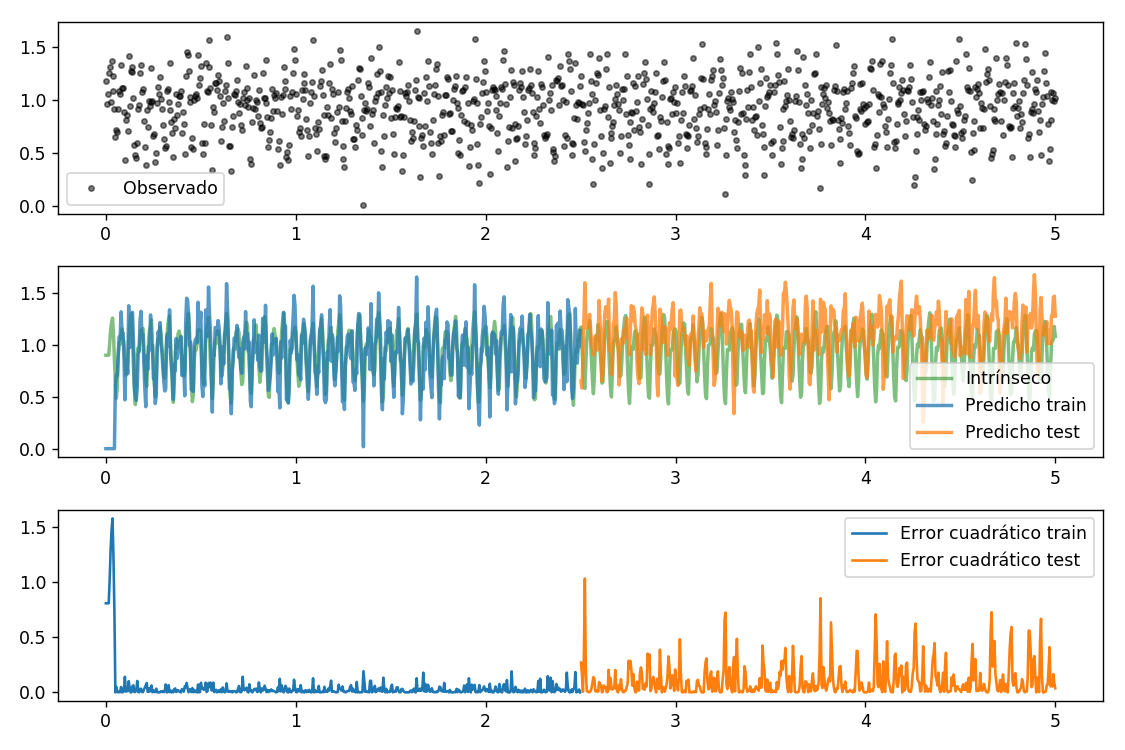

In [24]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=20 y $\tau = 17$

In [25]:
rls = RLS_filter(L=20, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 236.1840, prueba 475.3396


<IPython.core.display.Javascript object>


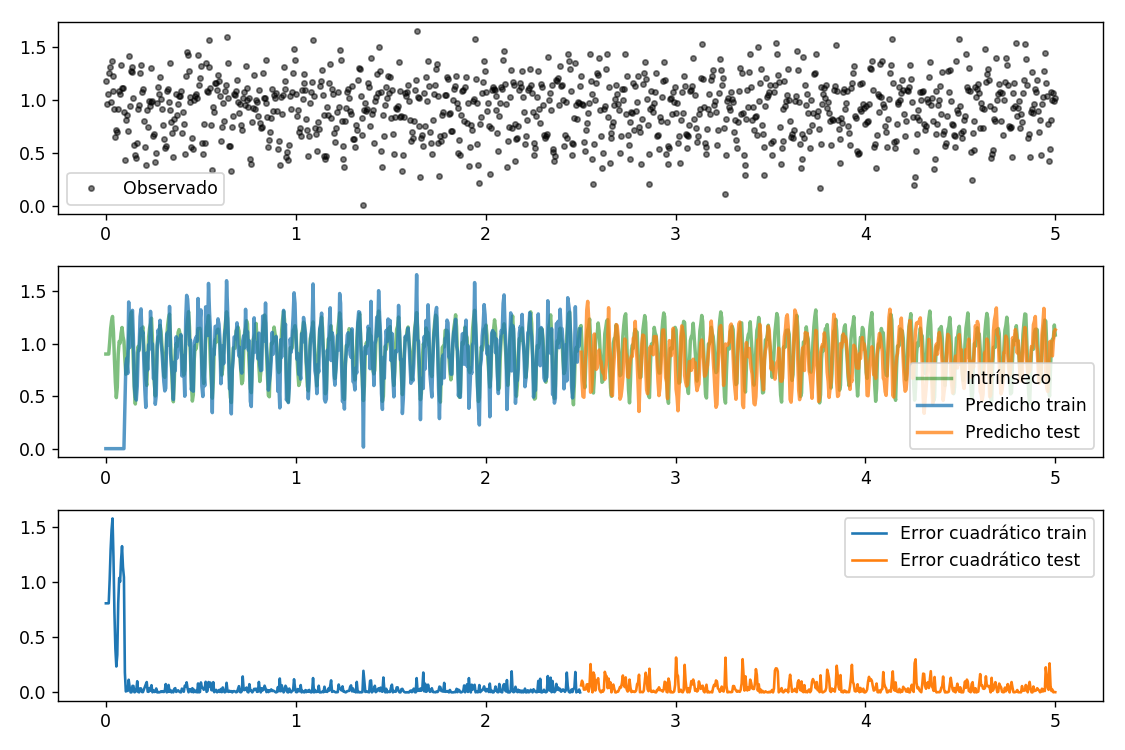

In [26]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=30 y $\tau = 17$

In [27]:
rls = RLS_filter(L=30, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 226.1382, prueba 345.8687


<IPython.core.display.Javascript object>


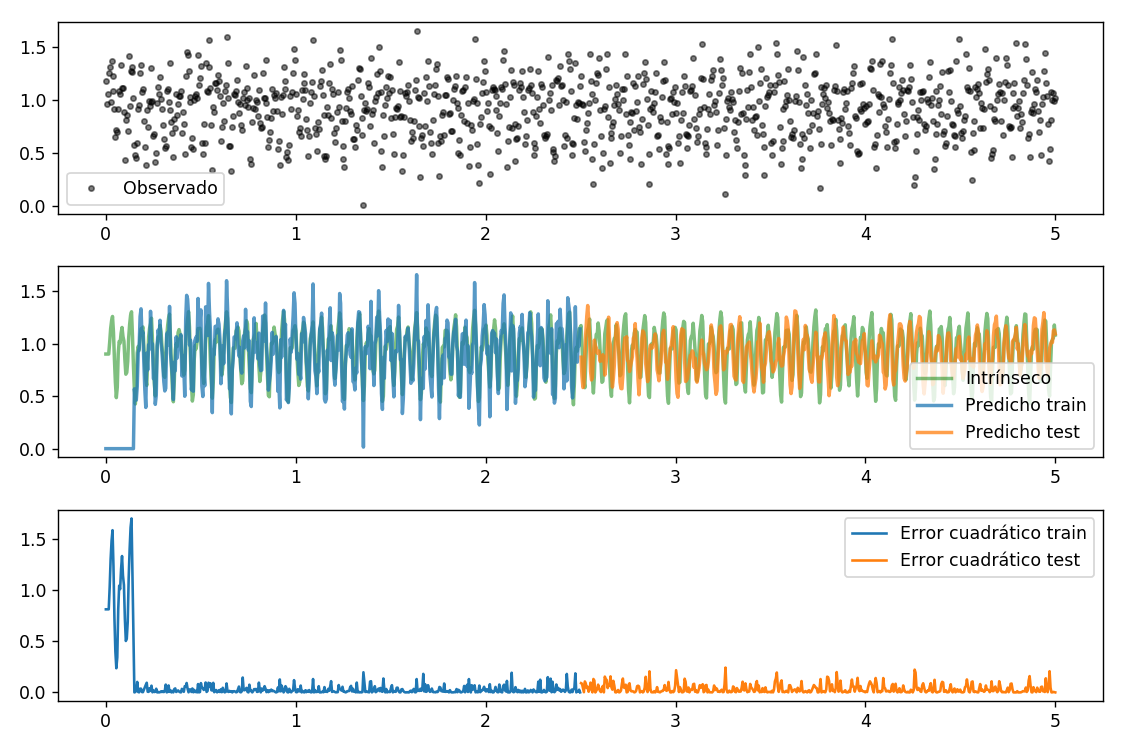

In [28]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

<IPython.core.display.Javascript object>


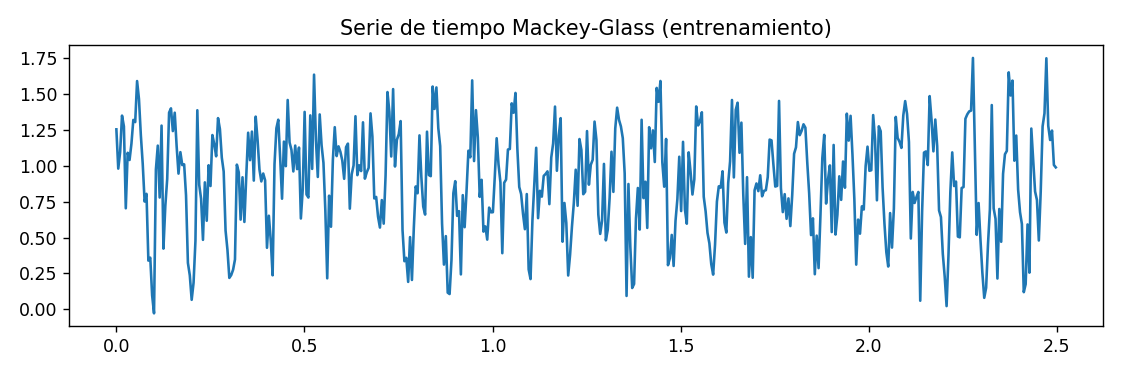

In [29]:
N = 1000 # número de observaciones (no modificar)
SNR = 2. # Razón señal a ruido (2., 0.5)
a, b = 0.1, 0.2 # constantes de la ecuación diferencial (no modificar)
tau = 30. # comportamiento dinámico de Mackey-Glass (17, 30)
dt = 0.05# paso de integración (no modificar)
y0 = 0.9 # condición incial (no modificar)
tt = 5.# largo temporal (no modificar)

t = np.linspace(0, tt, num=N)
#arreglo empieza en 0, termina en tt, N muestras

N_full, tau_full = int(N*tt/dt), int(tau/dt)

ymg = y0*np.ones(shape=(N_full, ))


# Runge-Kutta integration
for n in range(tau_full, N_full-1):
    byd = b*ymg[n-tau_full]/(1.0 + ymg[n-tau_full]**10.0)
    yk1 = dt*(-a*ymg[n] + byd)
    yk2 = dt*(-a*(ymg[n]+yk1/2) + byd)
    yk3 = dt*(-a*(ymg[n]+yk2/2) + byd)
    yk4 = dt*(-a*(ymg[n]+yk3) + byd)
    ymg[n+1] = ymg[n] + yk1/6 + yk2/3 +yk3/3 +yk4/6;


ymg = ymg[::int(tt/dt)]
#ymg = ymg - np.mean(ymg) 


# Contaminación con ruido blanco aditivo
s_noise = np.sqrt(np.var(ymg)/SNR) 
np.random.seed(0)
y_obs = ymg + s_noise*np.random.randn(len(ymg))


# Gráfico
fig, ax = plt.subplots(1, figsize=(9, 3), tight_layout=True)
ax.plot(t[:500], y_obs[:500])
ax.set_title('Serie de tiempo Mackey-Glass (entrenamiento)');

usando L=5 y $\tau = 30$

In [30]:
rls = RLS_filter(L=5, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 212.5978, prueba 617.3084


<IPython.core.display.Javascript object>


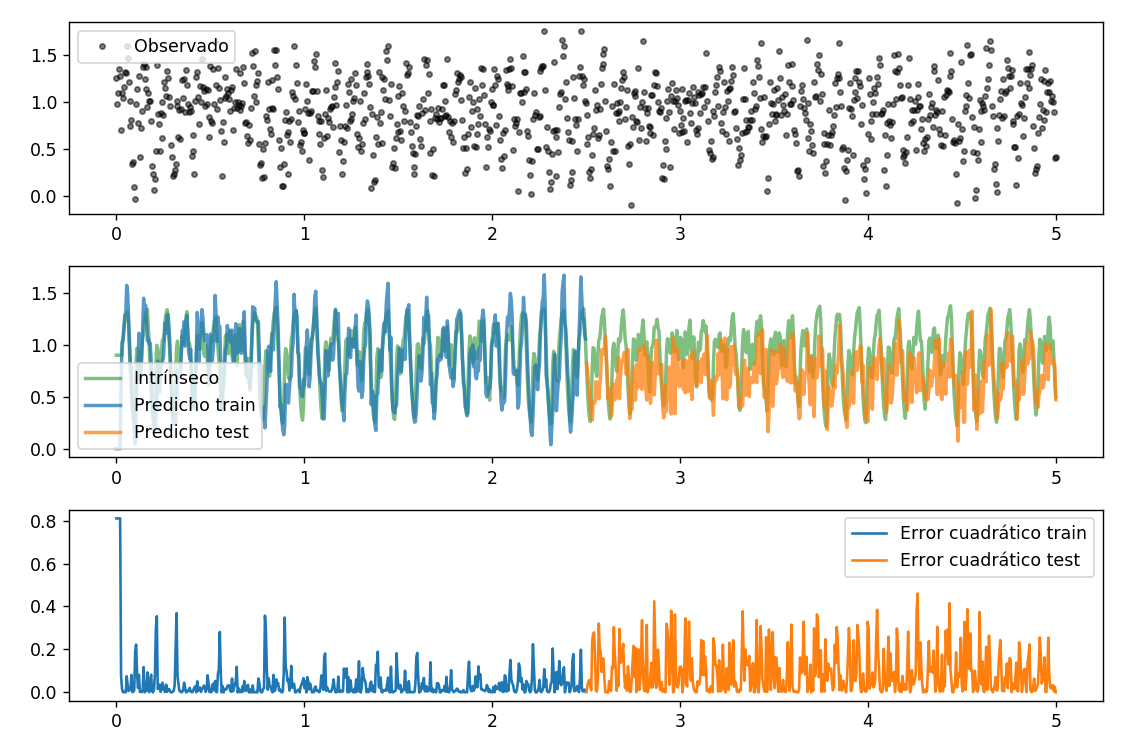

In [31]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=10 y $\tau = 30$

In [32]:
rls = RLS_filter(L=10, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 225.7695, prueba 2183.2111


<IPython.core.display.Javascript object>


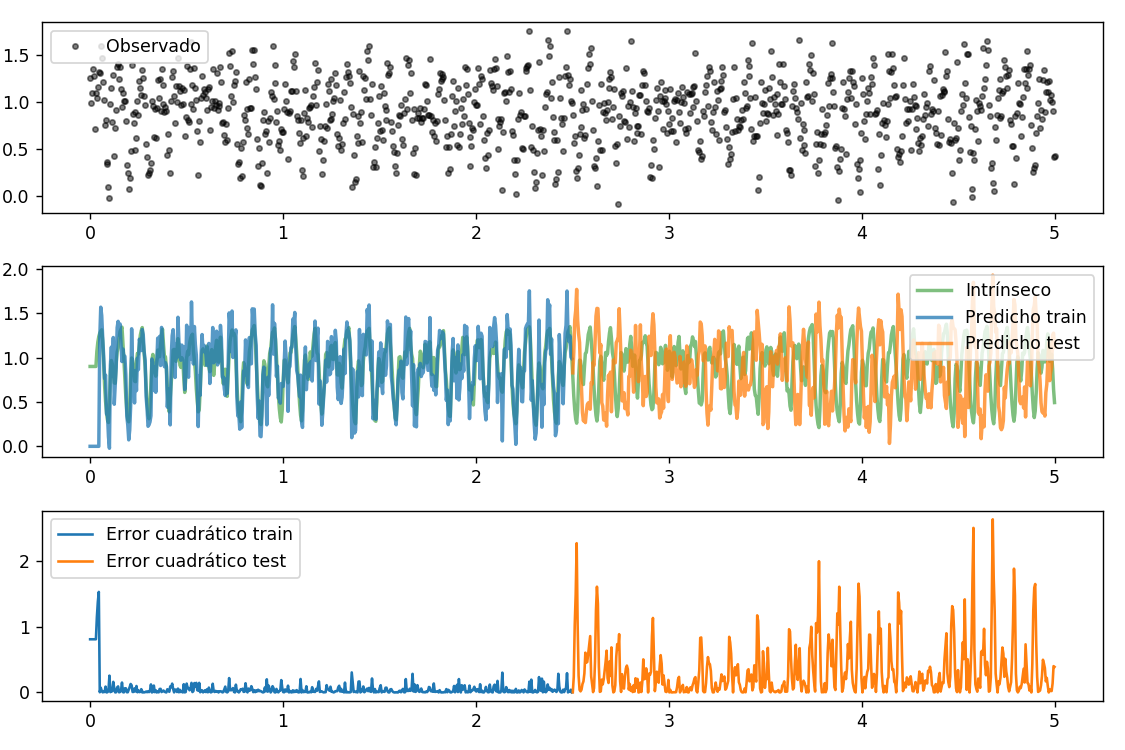

In [33]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=20 y $\tau = 30$

In [34]:
rls = RLS_filter(L=20, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 232.8087, prueba 2345.3333


<IPython.core.display.Javascript object>


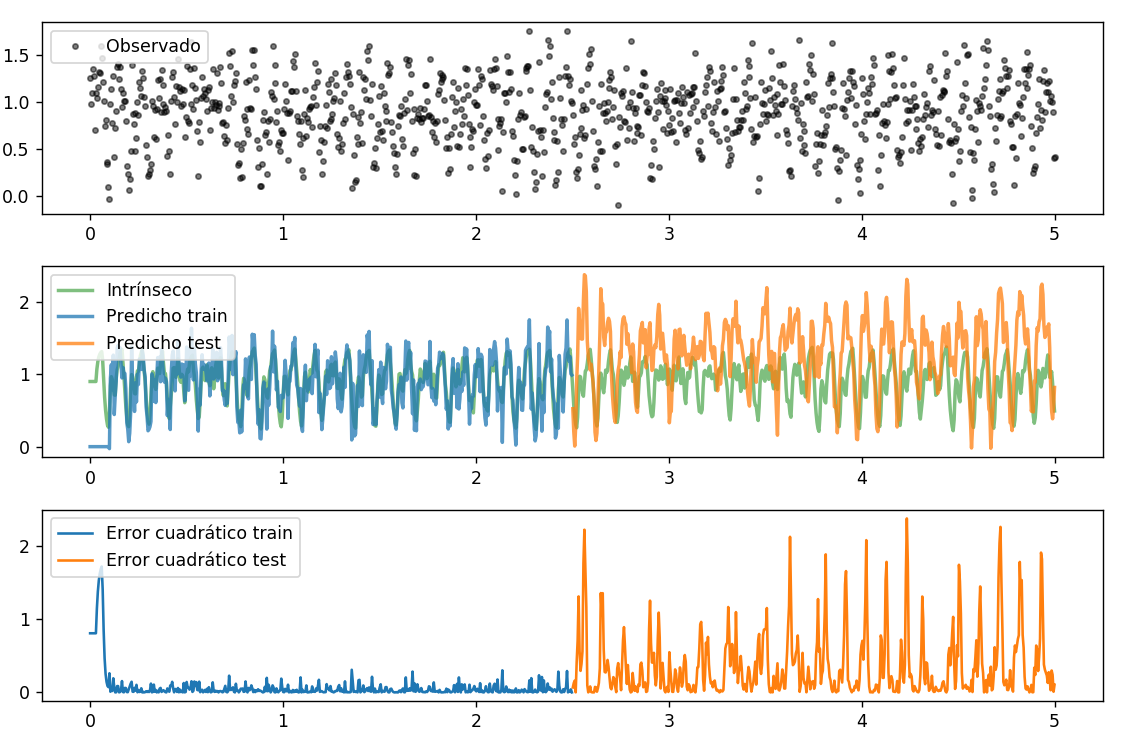

In [35]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

usando L=30 y $\tau = 30$

In [36]:
rls = RLS_filter(L=20, beta=0.9, delta=1.)
# Entrenamiento
y_pred = np.zeros(shape=(len(y_obs), ))
for k in range(rls.__len__(), 500):
    y_window = y_obs[k-rls.__len__():k]
    rls.update(d=y_obs[k], u=y_window)
    y_pred[k] = rls.predict(y_window)
# Prueba
for k in range(500, len(y_obs)):
    y_window = y_obs[k-rls.__len__():k]
    y_pred[k] = rls.predict(y_window)
    
print("MSE entrenamiento %0.4f, prueba %0.4f" %(NMSE(ymg[rls.__len__():500], y_pred[rls.__len__():500]), 
                                                NMSE(ymg[500:], y_pred[500:])))

MSE entrenamiento 232.8087, prueba 2345.3333


<IPython.core.display.Javascript object>


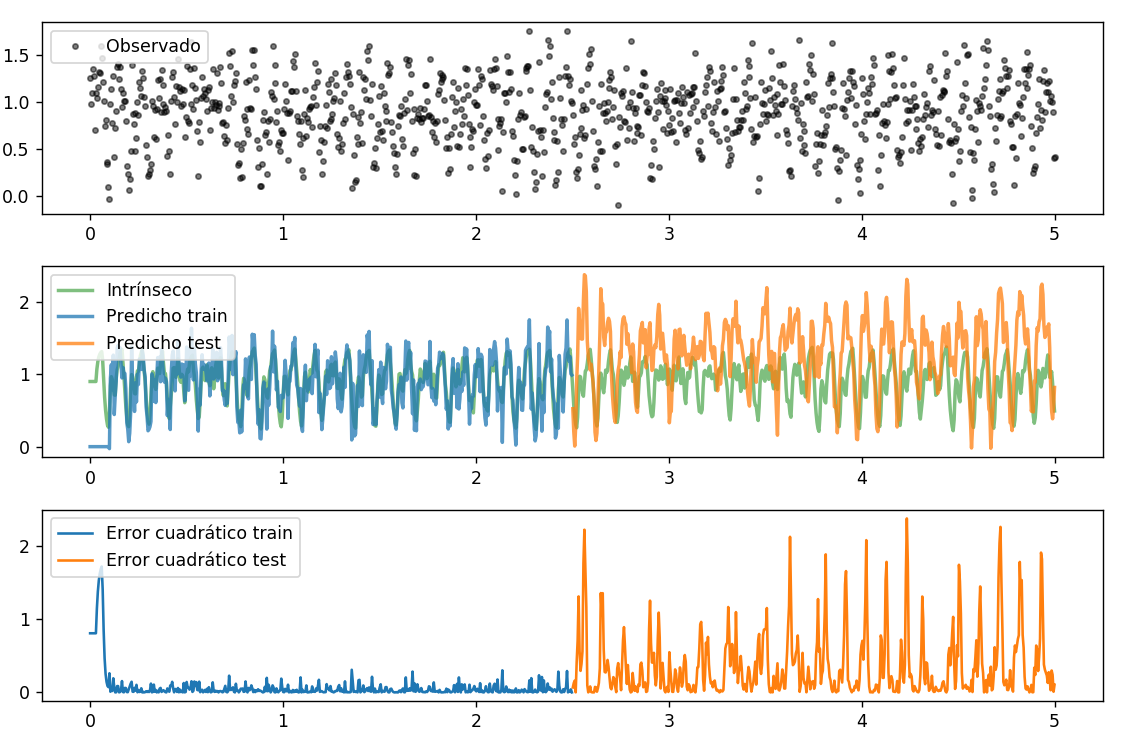

In [37]:
fig, ax = plt.subplots(3, figsize=(9, 6), tight_layout=True)
ax[0].plot(t, y_obs, 'k.', alpha=0.5, label='Observado'); ax[0].legend();
ax[1].plot(t, ymg, 'g-', alpha=0.5, lw=2, label='Intrínseco'); 
ax[1].plot(t[:500], y_pred[:500], alpha=0.75, lw=2, label='Predicho train'); 
ax[1].plot(t[500:], y_pred[500:], alpha=0.75, lw=2, label='Predicho test'); ax[1].legend();

ax[2].plot(t[:500], (ymg[:500] - y_pred[:500])**2, label='Error cuadrático train'); 
ax[2].plot(t[500:], (ymg[500:] - y_pred[500:])**2, label='Error cuadrático test'); ax[2].legend(); 

NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)